<div class="alert alert-success">
    <b>V3.</b>
    Thanks for taking the time to improve the project! Based on the AUC ROC of your best model, you've got 6 SP. Congratulations!
</div>

# Review
Hi, my name is Dmitry and I will be reviewing your project.

You can find my comments in colored markdown cells:

<div class="alert alert-success">
    If everything is done succesfully.
</div>

<div class="alert alert-warning">
    If I have some (optional) suggestions, or questions to think about, or general comments.
</div>

<div class="alert alert-danger">
    If a section requires some corrections. Work can't be accepted with red comments.
</div>

Please don't remove my comments, as it will make further review iterations much harder for me.

Feel free to reply to my comments or ask questions using the following template:

<div class="alert alert-info">
    For your comments and questions.
</div>

First of all, thank you for turning in the project! You did a pretty good job overall, there's only one small problem that needs to be fixed before the code can be accepted. It should be very straightforward though!

# Loading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

Let us load the data

In [2]:
contract=pd.read_csv('/datasets/final_provider/contract.csv')
personal=pd.read_csv('/datasets/final_provider/personal.csv')
internet=pd.read_csv('/datasets/final_provider/internet.csv')
phone=pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


BeginDate and EndDate need to be in datetime type. CustomerID can stay as is. Type, PaperlessBilling, and PaymentMethod needs to be in category type. Total charges can changed to float

In [5]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Apart from customerID, all columns need to be changed to the categorical type

In [7]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Apart from customerID, all the other columns need to be made into categories. We also see that there are less rows in this one, meaning not every client subscribed to the Internet service

In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Less rows than the first 2 tables, MultipleLines column needs to be made categorical

We have looked at the different tables. They need some processing, after which they need to be merged at some point. The latter will inevitably cause missing values since the tables don't have the same amount of rows. We will also have to deal with those

# Data Preprocessing

We start with the contract information.We make TotalCharges a float type. We will change the needed columns to categorical type. When dealing with EndDate, we notice some rows where it takes the value 'No' (the customer didn't leave). We will use that to create a 'churn' which will take a value of 0 when the customer didn't leave, 1 when he did. This new column becomes our target

In [11]:
#Contract
contract['Type']=contract['Type'].astype('category')
contract['PaperlessBilling']=contract['PaperlessBilling'].astype('category')
contract['PaymentMethod']=contract['PaymentMethod'].astype('category')
contract['TotalCharges']=pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract['churn'] = (contract['EndDate'] != "No").astype("int")

We can also create a 'days' column by getting the difference between the EndDate and BeginDate. They are still object types at this point. We will replace every 'No' in EndDate with the day the data was taken February 1, 2020. This date will be entered following the format present in the column (2020-02-01 00:00:00) to make it easy to change the column to datetime type. Then we can get difference and store in the 'days' column 

In [12]:
contract['EndDate']=contract['EndDate'].replace('No','2020-02-01 00:00:00')
contract['BeginDate']=pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate']=pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null datetime64[ns]
Type                7043 non-null category
PaperlessBilling    7043 non-null category
PaymentMethod       7043 non-null category
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
churn               7043 non-null int64
dtypes: category(3), datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 351.3+ KB


In [13]:
contract['days']=(contract['EndDate'] - contract['BeginDate']).dt.days
contract['days'].unique()

array([  31, 1036,   61, 1371,  245,  671,  306,  853, 1888,  396,  488,
       1767, 1491,  761, 2102, 1584, 2163,  304,  641,   30,  365, 1492,
        914, 1431, 2191,  518,   62,  822,  153, 1401, 1033,  335, 2132,
       1918, 1310,  456, 1826,  549, 2010, 1432,  275,   92,  945, 1523,
       1949, 1706,  337,  214, 1279,  276, 1067, 1461,  883, 1979, 1157,
       2071,  975, 1675, 1126, 1095,  303, 1248,  184,   91,  215,  123,
       1006, 2041,  702, 1737,  242, 1857,  457,  427,  610, 1614,  395,
       1218, 1798,  730, 1340,  579,  122, 1645, 1553,  580, 1795,  487,
       1583,  548,  974, 1156, 1309, 1917,  640,  760,  334, 2101,  669,
       1676, 1856,  792,  852,    0, 1217,  699, 1186, 1065, 1703,  273,
        607, 1003, 1369,  609, 1005, 1399, 1887, 1187, 1765, 2129,  638,
       1522,  183, 1064, 1338, 2160,  972,  244,  791,  426, 1125, 1796,
       2130, 1034, 1430,  913, 2040, 1278, 1400, 2009,  944, 1734, 2099,
       1764,  700,  668, 1736, 1370, 1644, 2070,  8

We now drop the 'Date' columns since they no longer have any use

In [14]:
contract_final=contract.drop(['BeginDate', 'EndDate'], axis=1)

We can also take out the missing-value rows caused by changing TotalCharges to float type

In [15]:
contract_final.dropna(inplace=True)

In [16]:
contract_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7032 non-null object
Type                7032 non-null category
PaperlessBilling    7032 non-null category
PaymentMethod       7032 non-null category
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
churn               7032 non-null int64
days                7032 non-null int64
dtypes: category(3), float64(2), int64(2), object(1)
memory usage: 350.6+ KB


We move to the Personal information. Except for customerID, we change the other columns to categorical type

In [17]:
#Personal
personal['gender']=personal['gender'].astype('category')
personal['Partner'] = personal['Partner'].astype("category")
personal['Dependents'] = personal['Dependents'].astype("category")
personal['SeniorCitizen'] = personal['SeniorCitizen'].astype("category")

In [18]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null category
SeniorCitizen    7043 non-null category
Partner          7043 non-null category
Dependents       7043 non-null category
dtypes: category(4), object(1)
memory usage: 83.0+ KB


We won't make the columns of the other tables categorical just yet, since they will make NaN values which we will need to replace with a value, so we will just go ahead with the merging. We will merge all the tables on the customerID column. Firstly, contract_final to personal tables

In [19]:
#Merging
merge_1=pd.merge(personal, contract_final, how="left", on="customerID")
merge_1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0


We take down the missing values caused by the difference in number of rows (We can't replace the information in these rows)

In [20]:
merge_1.dropna(inplace=True)
merge_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 12 columns):
customerID          7032 non-null object
gender              7032 non-null category
SeniorCitizen       7032 non-null category
Partner             7032 non-null category
Dependents          7032 non-null category
Type                7032 non-null category
PaperlessBilling    7032 non-null category
PaymentMethod       7032 non-null category
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
churn               7032 non-null float64
days                7032 non-null float64
dtypes: category(7), float64(4), object(1)
memory usage: 378.5+ KB


Second merge, phone subscription information

In [21]:
merge_2=pd.merge(merge_1, phone, how="left", on="customerID")
merge_2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,NaN
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,NaN
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No


Final merge, Internet subscription information

In [22]:
data_final=pd.merge(merge_2, internet, how="left", on="customerID")
data_final.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0,No,Fiber optic,No,No,No,No,No,No


In [23]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
customerID          7032 non-null object
gender              7032 non-null category
SeniorCitizen       7032 non-null category
Partner             7032 non-null category
Dependents          7032 non-null category
Type                7032 non-null category
PaperlessBilling    7032 non-null category
PaymentMethod       7032 non-null category
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
churn               7032 non-null float64
days                7032 non-null float64
MultipleLines       6352 non-null object
InternetService     5512 non-null object
OnlineSecurity      5512 non-null object
OnlineBackup        5512 non-null object
DeviceProtection    5512 non-null object
TechSupport         5512 non-null object
StreamingTV         5512 non-null object
StreamingMovies     5512 non-null object
dtypes: category(7), float64(4), object(9)
memory usage

In [24]:
data_final['churn']=data_final['churn'].astype('int') #changes churn column to integer type

Now we can replace those missing values. Since the users that have missing values in their rows don't subscribe to the service in those columns, we can replace the missing values by 'No'

In [25]:
#Replacing missing values with 'Not Applied'
str_cols = data_final.columns[data_final.dtypes=='object']
data_final[str_cols] = data_final[str_cols].fillna('No')

In [26]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
customerID          7032 non-null object
gender              7032 non-null category
SeniorCitizen       7032 non-null category
Partner             7032 non-null category
Dependents          7032 non-null category
Type                7032 non-null category
PaperlessBilling    7032 non-null category
PaymentMethod       7032 non-null category
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
churn               7032 non-null int64
days                7032 non-null float64
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
dtypes: category(7), float64(3), int64(1), object(9)
memo

We can now do our categorical type conversions now

In [27]:
#converting to categorical columns
data_final['OnlineSecurity'] = (data_final['OnlineSecurity'] == "Yes").astype("category")
data_final['OnlineBackup'] = (data_final['OnlineBackup'] == "Yes").astype("category")
data_final['TechSupport'] = (data_final['TechSupport'] == "Yes").astype("category")
data_final['DeviceProtection'] = (data_final['DeviceProtection'] == "Yes").astype("category")
data_final['StreamingTV'] = (data_final['StreamingTV'] == "Yes").astype("category")
data_final['StreamingMovies'] = (data_final['StreamingMovies'] == "Yes").astype("category")
data_final['InternetService'] = data_final['InternetService'].astype('category')
data_final['MultipleLines'] = (data_final['MultipleLines'] == "Yes").astype("category")

data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
customerID          7032 non-null object
gender              7032 non-null category
SeniorCitizen       7032 non-null category
Partner             7032 non-null category
Dependents          7032 non-null category
Type                7032 non-null category
PaperlessBilling    7032 non-null category
PaymentMethod       7032 non-null category
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
churn               7032 non-null int64
days                7032 non-null float64
MultipleLines       7032 non-null category
InternetService     7032 non-null category
OnlineSecurity      7032 non-null category
OnlineBackup        7032 non-null category
DeviceProtection    7032 non-null category
TechSupport         7032 non-null category
StreamingTV         7032 non-null category
StreamingMovies     7032 non-null category
dtypes: category(15), float64(3), int64(1

We have processed our data. We can now move on to Exploratory Data Analysis

<div class="alert alert-success">
    Dataframes were merged correctly, the preprocessing looks good, there doesn't seem to be any features that would leak target
</div>


# Exploratory Data Analysis

We will explore class imbalance in our dataset. Those who left versus those who stayed

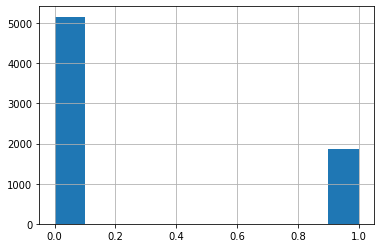

In [28]:
#Class Imbalance Histogram
data_final['churn'].hist()

Upwards of 5000 people stayed and a little less than 2000 left. Let us plot charts to see how the churn is distributed over the other characteristics

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handl

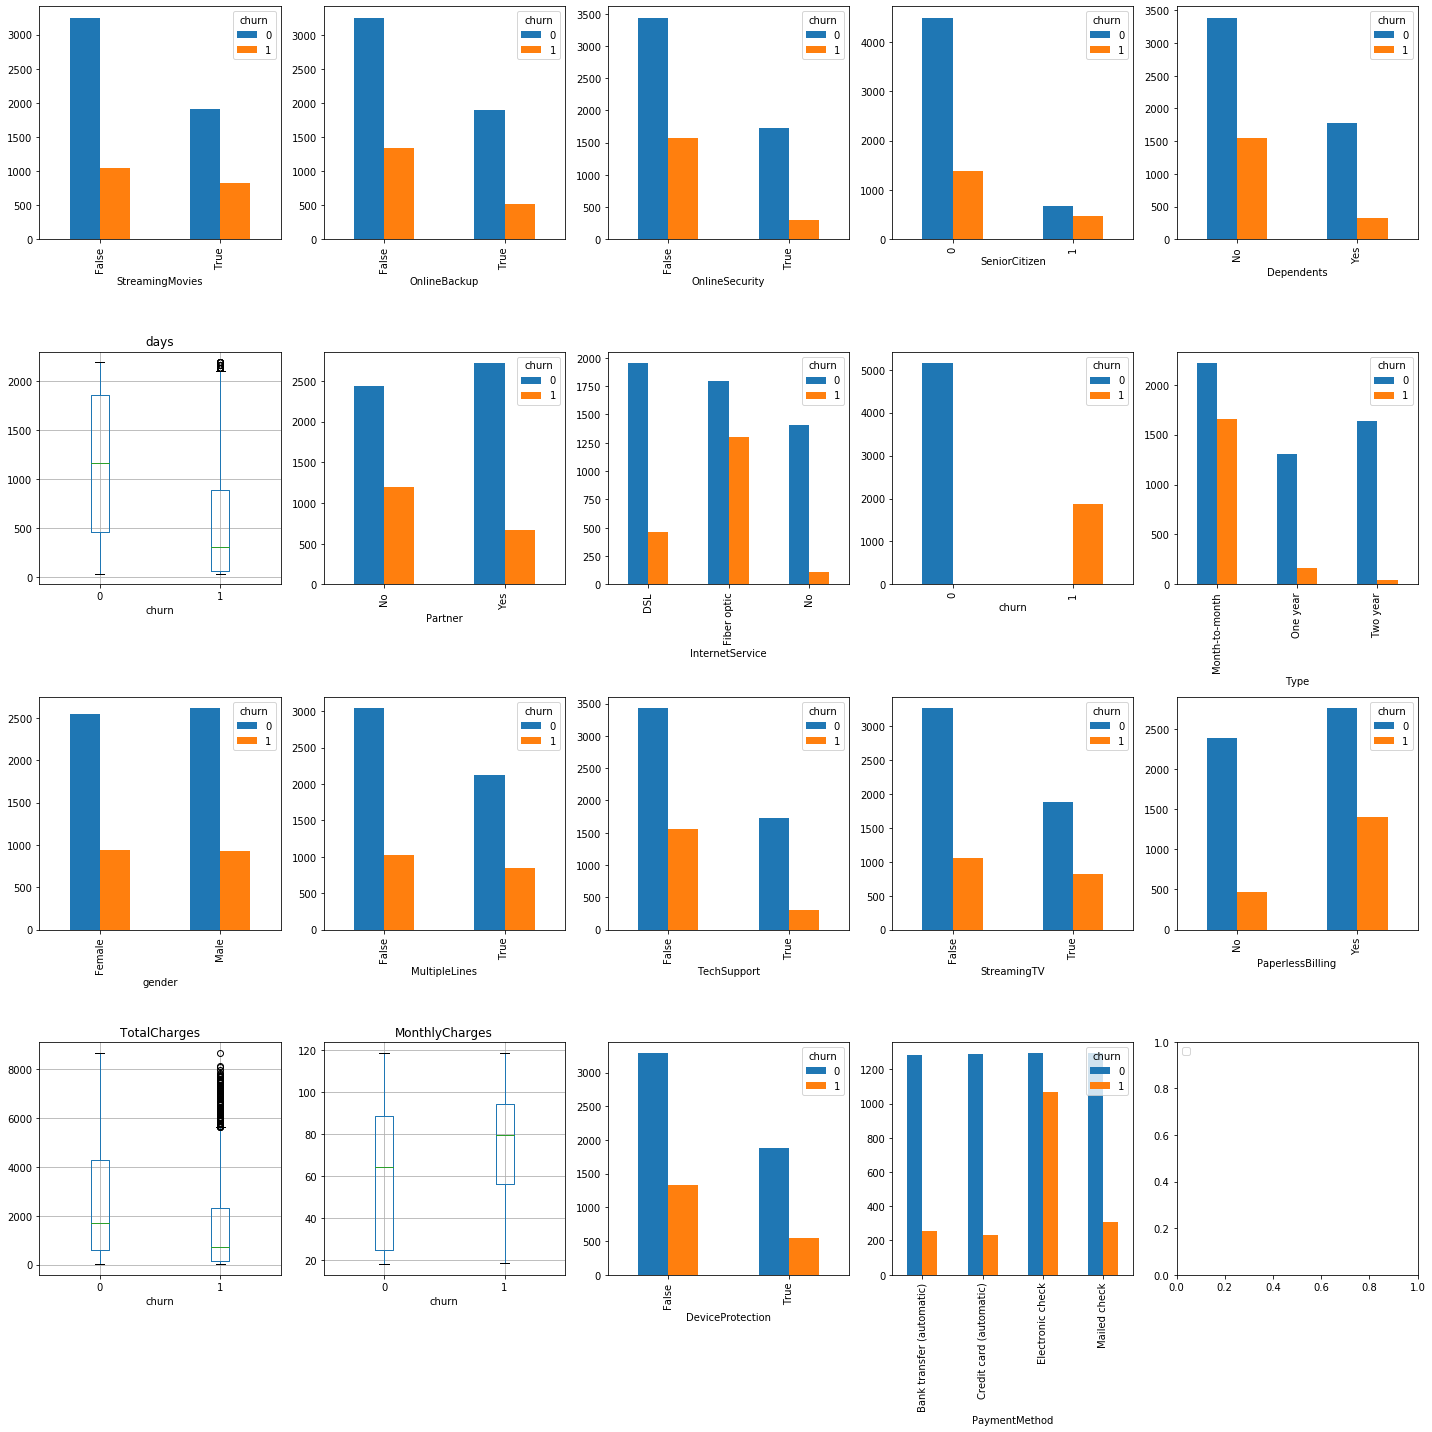

In [29]:
#Plot graphs with features vs the churn. Boxplots for discrete features, bar charts for categorical values
fig, axs = plt.subplots(4, len(data_final.columns) // 4, figsize=(20,20))
axs = axs.flatten()
cols=list(set(data_final.columns) - set(['customerID']))
for col, ax in zip(cols, axs):
    if data_final[col].dtype=='float64':
        data_final.boxplot(column=col, by='churn', ax=ax)
        plt.suptitle('')
    else:
        df = data_final.groupby([col, 'churn'])['churn'].count().unstack()
        df.plot(kind='bar', stacked=False, label='#churn (neg, pos)', ax=ax)
        plt.legend(loc='upper left')
    
plt.tight_layout()
plt.show()    

What we can gather is that most people who left:
* Had paperless billing, especially through electronic cheque
* Were not senior citizens
* Didn't have one or more of the services from the internet subscription
* Were month-to-month payers

Their monthly charges were typically higher (about 80USD on average), they are typically newer users based on the 'days' boxplot (with a few outliers), and they paid typically less charges in total since they typically didn't stay long (even though we observe a lot of outliers). Let us take a look at the correlation matrix

In [30]:
data_final.corr()

,MonthlyCharges,TotalCharges,churn,days
MonthlyCharges,1.000000,0.651065,0.192858,0.246715
TotalCharges,0.651065,1.000000,-0.199484,0.825811
churn,0.192858,-0.199484,1.000000,-0.354496
days,0.246715,0.825811,-0.354496,1.000000


No none of the numerical features have a strong correlation with churn. A notably strong correlation exists between the number of days and the total charges paid

We will now look at monthly charges for subscribers to the phone and internet services, and for each service, compare their distribution among those who left and those who didn't

In [31]:
phone_users=data_final[data_final['customerID'].isin(phone['customerID'])]
phone_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6352 entries, 1 to 7031
Data columns (total 20 columns):
customerID          6352 non-null object
gender              6352 non-null category
SeniorCitizen       6352 non-null category
Partner             6352 non-null category
Dependents          6352 non-null category
Type                6352 non-null category
PaperlessBilling    6352 non-null category
PaymentMethod       6352 non-null category
MonthlyCharges      6352 non-null float64
TotalCharges        6352 non-null float64
churn               6352 non-null int64
days                6352 non-null float64
MultipleLines       6352 non-null category
InternetService     6352 non-null category
OnlineSecurity      6352 non-null category
OnlineBackup        6352 non-null category
DeviceProtection    6352 non-null category
TechSupport         6352 non-null category
StreamingTV         6352 non-null category
StreamingMovies     6352 non-null category
dtypes: category(15), float64(3), int64(1

Distribution of monthly charges among phone users

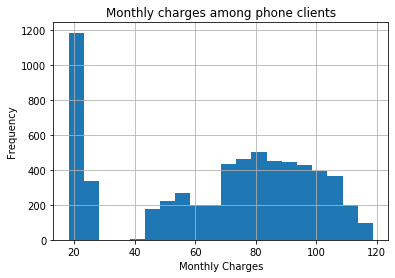

In [32]:
phone_users['MonthlyCharges'].hist(bins=20)
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Monthly charges among phone clients')
plt.show()

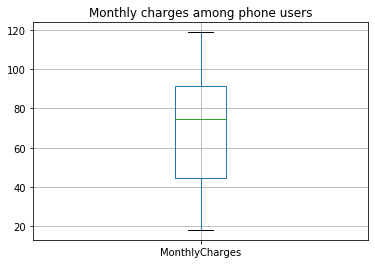

In [33]:
phone_users.boxplot(column='MonthlyCharges')
plt.title('Monthly charges among phone users')
plt.show()

In [34]:
phone_users['MonthlyCharges'].describe()

count    6352.000000
mean       67.239625
std        30.438439
min        18.250000
25%        44.787500
50%        74.700000
75%        91.250000
max       118.750000
Name: MonthlyCharges, dtype: float64

A typical phone user is typically charged anywhere between about 45 (25-percentile) and about 91 (75-percentile). However, according to the histogram, there is a good number of people (about 1500) who pay between 20 and 30 monthly. Let us now check the distribution among those who left and those who stayed

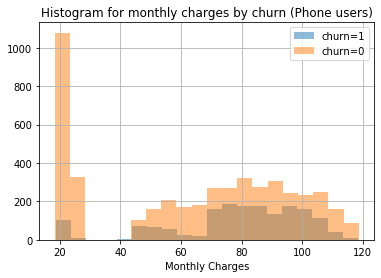

In [35]:
phone_users[phone_users['churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
phone_users[phone_users['churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('Histogram for monthly charges by churn (Phone users)')
plt.show()

The distributions are quite similar, even though that for those who left is much smaller

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


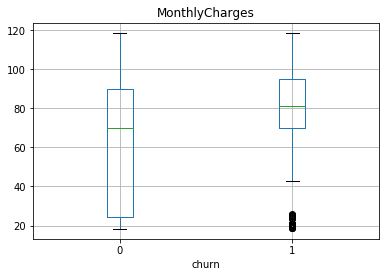

In [36]:
phone_users.boxplot(column='MonthlyCharges', by='churn')
plt.suptitle('')
plt.show()

Those who left typically paid higher monthly charges than those who stayed

In [37]:
print('Monthly Charge distribution for those who left',
      phone_users[phone_users['churn']==1]['MonthlyCharges'].describe())
print('-----------------------------------------------------------')
print('Monthly Charge distribution for those who stayed',
      phone_users[phone_users['churn']==0]['MonthlyCharges'].describe())

Monthly Charge distribution for those who left count    1699.000000
mean       78.134255
std        22.567643
min        18.850000
25%        69.975000
50%        80.950000
75%        94.850000
max       118.350000
Name: MonthlyCharges, dtype: float64
-----------------------------------------------------------
Monthly Charge distribution for those who stayed count    4653.000000
mean       63.261552
std        31.934310
min        18.250000
25%        24.500000
50%        69.900000
75%        90.050000
max       118.750000
Name: MonthlyCharges, dtype: float64


Those who left typically paid between about 70 (25-percentile) and about 95 (75-percentile). While those who stayed typically paid between about 24 (25-percentile) and about 90 (75-percentile)

We will be repeating the above steps for the Internet subscribers

In [38]:
internet_users=data_final[data_final['customerID'].isin(internet['customerID'])]
internet_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5512 entries, 0 to 7031
Data columns (total 20 columns):
customerID          5512 non-null object
gender              5512 non-null category
SeniorCitizen       5512 non-null category
Partner             5512 non-null category
Dependents          5512 non-null category
Type                5512 non-null category
PaperlessBilling    5512 non-null category
PaymentMethod       5512 non-null category
MonthlyCharges      5512 non-null float64
TotalCharges        5512 non-null float64
churn               5512 non-null int64
days                5512 non-null float64
MultipleLines       5512 non-null category
InternetService     5512 non-null category
OnlineSecurity      5512 non-null category
OnlineBackup        5512 non-null category
DeviceProtection    5512 non-null category
TechSupport         5512 non-null category
StreamingTV         5512 non-null category
StreamingMovies     5512 non-null category
dtypes: category(15), float64(3), int64(1

The distribution of monthly charges among internet users

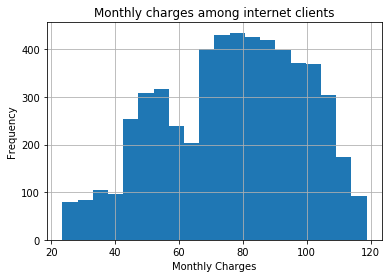

In [39]:
internet_users['MonthlyCharges'].hist(bins=20)
plt.xlabel('Monthly Charges')
plt.ylabel('Frequency')
plt.title('Monthly charges among internet clients')
plt.show()

We notice 2 peaks: one around 50, the other around 80. It is skewed to the right

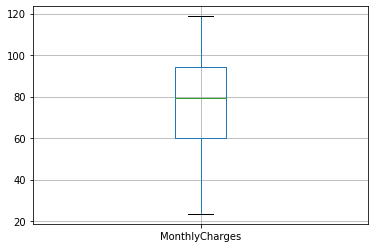

In [40]:
internet_users.boxplot(column='MonthlyCharges')
plt.show()

In [41]:
internet_users['MonthlyCharges'].describe()

count    5512.000000
mean       76.855053
std        21.929331
min        23.450000
25%        59.950000
50%        79.500000
75%        94.450000
max       118.750000
Name: MonthlyCharges, dtype: float64

Internet users get typically charged between around 60 (25-percentile) and around 95 (75-percentile) monthly. Let's now break down the distribution by churn

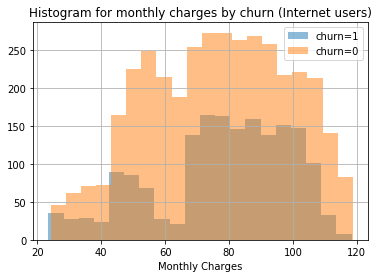

In [42]:
internet_users[internet_users['churn']==1]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=1')
internet_users[internet_users['churn']==0]['MonthlyCharges'].hist(bins=20, alpha=0.5, label='churn=0')
plt.legend(loc='upper right')
plt.xlabel('Monthly Charges')
plt.title('Histogram for monthly charges by churn (Internet users)')
plt.show()

Again, we notice similar distributions, though the frequencies vary (majority of the people stayed)

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


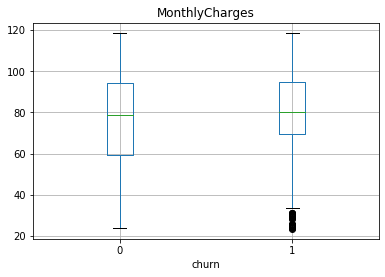

In [43]:
internet_users.boxplot(column='MonthlyCharges', by='churn')
plt.suptitle('')
plt.show()

In [44]:
print('Monthly Charge distribution for those who left',
      internet_users[internet_users['churn']==1]['MonthlyCharges'].describe())
print('-----------------------------------------------------------')
print('Monthly Charge distribution for those who stayed',
      internet_users[internet_users['churn']==0]['MonthlyCharges'].describe())

Monthly Charge distribution for those who left count    1756.000000
mean       77.920985
std        21.144147
min        23.450000
25%        69.350000
50%        80.450000
75%        94.650000
max       118.350000
Name: MonthlyCharges, dtype: float64
-----------------------------------------------------------
Monthly Charge distribution for those who stayed count    3756.000000
mean       76.356709
std        22.272199
min        24.150000
25%        59.137500
50%        78.725000
75%        94.312500
max       118.750000
Name: MonthlyCharges, dtype: float64


Those who left typically paid between about 69 (25-percentile) and about 95 (75-percentile). While those who stayed typically paid between about 59 (25-percentile) and about 94 (75-percentile)

In conclusion, for both internet and phone sets of users, those who left general typically paid more monthly

<div class="alert alert-success">
    Nice EDA!
</div>


# Model Training

Let us finish processing our dataset

We can drop the customerID column since it will be of no use

In [45]:
data_final=data_final.drop('customerID', axis=1)

<div class="alert alert-success">
    Makes sense, it's just a database identifier with no inherent meaning
</div>


We can now split our data into training and data sets. We will use 3 types of data. One with Ordinal Encoding & scaling, the second with One-Hot Encoding & scaling, the 3rd scaled with no encoding. Each of these will be upsampled due to the class imbalance that exists. Our upsampling function is below

In [46]:
#Upsampling
def upsample(features, target, repeat):
#creates a function called upsample which takes features, target, and repeat number as arguments
    features_zeros = features[target == 0]#gets the negative class features
    features_ones = features[target == 1]#gets the positive class features 
    target_zeros = target[target == 0]#gets the negative class of the target
    target_ones = target[target == 1]#gets the positive class of the target
    features_ups = pd.concat([features_zeros] + [features_ones] * repeat)
    #upsamples the features by combining the negative class features and the repeated positive class features
    target_ups = pd.concat([target_zeros] + [target_ones] * repeat)
    #upsamples the target by combining the negative class target and the repeated positive class target
    features_ups, target_ups = shuffle(features_ups, target_ups, random_state=12345)
    #shuffles the resulting upsampled features and targets
    return features_ups, target_ups # returns the resulting upsampled features and target

<div class="alert alert-success">
    Upsampling function is fine
</div>


## Ordinal Encoding and Scaling

In [47]:
data_mod=data_final.copy()
cat_feat = data_mod.columns[data_mod.dtypes=='category']
encoder=OrdinalEncoder()#creates an instance of the ordinal encoder
data_mod[cat_feat]=encoder.fit_transform(data_mod[cat_feat])#encodes the columns
data_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 19 columns):
gender              7032 non-null float64
SeniorCitizen       7032 non-null float64
Partner             7032 non-null float64
Dependents          7032 non-null float64
Type                7032 non-null float64
PaperlessBilling    7032 non-null float64
PaymentMethod       7032 non-null float64
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
churn               7032 non-null int64
days                7032 non-null float64
MultipleLines       7032 non-null float64
InternetService     7032 non-null float64
OnlineSecurity      7032 non-null float64
OnlineBackup        7032 non-null float64
DeviceProtection    7032 non-null float64
TechSupport         7032 non-null float64
StreamingTV         7032 non-null float64
StreamingMovies     7032 non-null float64
dtypes: float64(18), int64(1)
memory usage: 1.1 MB


In [48]:
features=data_mod.drop('churn', axis=1)#features will be all columns except churn column
target=data_mod['churn']#target will be the churn column
features_train, features_test, target_train, target_test=train_test_split(features, target,\
                                                                                      test_size=0.25,\
                                                                                     random_state=12345)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5274, 18)
(5274,)
(1758, 18)
(1758,)


<div class="alert alert-success">
    The split into train and test sets is reasonable. Target feature fits the task
</div>


In [49]:
target_train.value_counts(normalize=True) #class imbalance

0    0.733788
1    0.266212
Name: churn, dtype: float64

In [50]:
feat_ups, targ_ups = upsample(features_train, target_train, 3)
#upsamples the training set of features and target by inputing them in the upsample function with a repeat
#value of 3
print(feat_ups.shape, targ_ups.shape)#prints the dimensions of the upsampled sets

(8082, 18) (8082,)


In [51]:
#Scaling numeric columns
numeric = ['MonthlyCharges', 'TotalCharges', 'days']
#creates a list containing the numeric column names
scaler = StandardScaler()#calling the scale function
scaler.fit(feat_ups[numeric])#trains the scaler with the data from the numeric columns
feat_ups[numeric] = scaler.transform(feat_ups[numeric])#transforms the data into scaled values
features_test[numeric] = scaler.transform(features_test[numeric])
feat_ups.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3498: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1616,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.637200,0.452304,0.305534,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5677,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.591817,-0.702195,-0.896508,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
6137,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.092781,0.150571,-0.108351,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
1681,0.0,0.0,1.0,1.0,0.0,1.0,2.0,-0.284435,-0.193608,-0.067372,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6142,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.097834,-0.624962,-0.774938,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## One-Hot Encoding and scaling

In [52]:
data_ohe=pd.get_dummies(data_final, drop_first=True)
data_ohe.head()

,MonthlyCharges,TotalCharges,churn,days,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,...,PaymentMethod_Mailed check,MultipleLines_True,InternetService_Fiber optic,InternetService_No,OnlineSecurity_True,OnlineBackup_True,DeviceProtection_True,TechSupport_True,StreamingTV_True,StreamingMovies_True
0,29.85,29.85,0,31.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,56.95,1889.50,0,1036.0,1,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
2,53.85,108.15,1,61.0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
3,42.30,1840.75,0,1371.0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,1,0,0
4,70.70,151.65,1,61.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [53]:
feat=data_ohe.drop('churn', axis=1)#features will be all columns except churn column
target=data_ohe['churn']#target will be the churn column
f_train, f_test, t_train, t_test=train_test_split(feat, target,\
                                                                                      test_size=0.25,\
                                                                                     random_state=12345)
print(f_train.shape)
print(t_train.shape)
print(f_test.shape)
print(t_test.shape)

(5274, 22)
(5274,)
(1758, 22)
(1758,)


In [54]:
f_ohe, t_ohe = upsample(f_train, t_train, 3)
print(f_ohe.shape, t_ohe.shape)

(8082, 22) (8082,)


In [55]:
numeric = ['MonthlyCharges', 'TotalCharges', 'days']
#creates a list containing the numeric column names
scaler = StandardScaler()#calling the scale function
scaler.fit(f_ohe[numeric])#trains the scaler with the data from the numeric columns
f_ohe[numeric] = scaler.transform(f_ohe[numeric])#transforms the data into scaled values
f_test[numeric] = scaler.transform(f_test[numeric])
f_ohe.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,MonthlyCharges,TotalCharges,days,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,...,PaymentMethod_Mailed check,MultipleLines_True,InternetService_Fiber optic,InternetService_No,OnlineSecurity_True,OnlineBackup_True,DeviceProtection_True,TechSupport_True,StreamingTV_True,StreamingMovies_True
1616,0.637200,0.452304,0.305534,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,1,0
5677,0.591817,-0.702195,-0.896508,1,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,1,0
6137,1.092781,0.150571,-0.108351,0,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,1
1681,-0.284435,-0.193608,-0.067372,0,0,1,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
6142,0.097834,-0.624962,-0.774938,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Scaling without Encoding (CatBoost and LGBM only)

In [56]:
no_enc=data_final.copy()
feat=no_enc.drop('churn', axis=1)#features will be all columns except churn column
target=no_enc['churn']#target will be the churn column
ft_train, ft_test, tr_train, tr_test=train_test_split(feat, target,\
                                                                                      test_size=0.25,\
                                                                                     random_state=12345)
print(ft_train.shape)
print(tr_train.shape)
print(ft_test.shape)
print(tr_test.shape)

(5274, 18)
(5274,)
(1758, 18)
(1758,)


In [57]:
f_ne, t_ne = upsample(ft_train, tr_train, 3)
print(f_ne.shape, t_ne.shape)

(8082, 18) (8082,)


In [58]:
numeric = ['MonthlyCharges', 'TotalCharges', 'days']
#creates a list containing the numeric column names
scaler = StandardScaler()#calling the scale function
scaler.fit(f_ne[numeric])#trains the scaler with the data from the numeric columns
f_ne[numeric] = scaler.transform(f_ne[numeric])#transforms the data into scaled values
ft_test[numeric] = scaler.transform(ft_test[numeric])
f_ne.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,days,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1616,Female,0,No,No,Month-to-month,Yes,Electronic check,0.637200,0.452304,0.305534,True,Fiber optic,False,False,False,False,True,False
5677,Male,1,No,No,Month-to-month,Yes,Bank transfer (automatic),0.591817,-0.702195,-0.896508,False,Fiber optic,True,False,False,False,True,False
6137,Female,0,No,No,Month-to-month,Yes,Electronic check,1.092781,0.150571,-0.108351,False,Fiber optic,False,True,True,False,True,True
1681,Female,0,Yes,Yes,Month-to-month,Yes,Electronic check,-0.284435,-0.193608,-0.067372,True,DSL,False,True,False,True,False,False
6142,Female,0,No,No,Month-to-month,No,Electronic check,0.097834,-0.624962,-0.774938,False,Fiber optic,False,False,False,False,False,False


<div class="alert alert-danger">
    <s>Upsampling, encoding of categorical features were applied correctly. But it looks like you forgot to also scale the test set (you are correctly fitting the scaler only using the train set, but if you don't transform the test set, as well as the train set, your models will encounter problems)
</div>


<div class="alert alert-info">
    Fixed
</div>

<div class="alert alert-success">
    <b>V2.</b>
    Great!
</div>

## Models

### Logistic Regression

In [59]:
#Cross-validating Logistic regression on data with Ordinal Encoding and scaling
lr = LogisticRegression(solver='liblinear')
lr_score=cross_val_score(lr, feat_ups, targ_ups, scoring='roc_auc', cv=5)
print(lr_score.mean())

0.836839486424871


In [60]:
#Training Logistic regression on data with One-Hot Encoding and scaling
lr = LogisticRegression(solver='liblinear')
lr_score=cross_val_score(lr, f_ohe, t_ohe, scoring='roc_auc', cv=5)
print(lr_score.mean())

0.8442112783213371


### Random Forest

In [61]:
#Random Forest Cross-validation using data with Ordinal Encoding and Scaling
for depth in range(21, 26):
    rf=RandomForestClassifier(n_estimators=40, max_depth=depth, random_state=12345)
    rf_score=cross_val_score(rf, feat_ups, targ_ups, scoring='roc_auc', cv=5)
    print('Max_depth', depth, 'score:', rf_score.mean())

Max_depth 21 score: 0.9794981497692191
Max_depth 22 score: 0.9792014508007542
Max_depth 23 score: 0.9789806589508052
Max_depth 24 score: 0.9794802267950187
Max_depth 25 score: 0.9791136162684507


In [62]:
#Random Forest Cross-validation using data with One-Hot Encoding and Scaling
for depth in range(21, 26):
    rf=RandomForestClassifier(n_estimators=40, max_depth=depth, random_state=12345)
    rf_score=cross_val_score(rf, f_ohe, t_ohe, scoring='roc_auc', cv=5)
    print('Max_depth', depth, 'score:', rf_score.mean())

Max_depth 21 score: 0.9781700948225028
Max_depth 22 score: 0.9784966434508752
Max_depth 23 score: 0.9779276846260739
Max_depth 24 score: 0.9777353454316857
Max_depth 25 score: 0.9781898349034643


### CatBoost

In [107]:
#Cross-validating CatBoost on data with Ordinal Encoding and scaling
cb=CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb_score=cross_val_score(cb, feat_ups, targ_ups, scoring='roc_auc', cv=5)

0:	learn: 0.6365897	total: 4.49ms	remaining: 4.49s
1:	learn: 0.6037797	total: 8.89ms	remaining: 4.44s
2:	learn: 0.5771772	total: 13.2ms	remaining: 4.4s
3:	learn: 0.5594858	total: 22.8ms	remaining: 5.68s
4:	learn: 0.5423472	total: 27.4ms	remaining: 5.45s
5:	learn: 0.5279168	total: 32ms	remaining: 5.3s
6:	learn: 0.5148573	total: 36.4ms	remaining: 5.17s
7:	learn: 0.5053446	total: 40.6ms	remaining: 5.04s
8:	learn: 0.4957615	total: 125ms	remaining: 13.7s
9:	learn: 0.4821018	total: 129ms	remaining: 12.8s
10:	learn: 0.4755198	total: 134ms	remaining: 12s
11:	learn: 0.4698800	total: 138ms	remaining: 11.4s
12:	learn: 0.4656392	total: 223ms	remaining: 16.9s
13:	learn: 0.4589436	total: 227ms	remaining: 16s
14:	learn: 0.4548884	total: 232ms	remaining: 15.2s
15:	learn: 0.4516174	total: 236ms	remaining: 14.5s
16:	learn: 0.4480575	total: 320ms	remaining: 18.5s
17:	learn: 0.4434117	total: 324ms	remaining: 17.7s
18:	learn: 0.4406266	total: 328ms	remaining: 17s
19:	learn: 0.4368284	total: 333ms	remaining

In [108]:
print(cb_score.mean())

0.9863410653073521


In [81]:
#Training CatBoost on data that was scaled but not encoded
cat_feat=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod']
cb=CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb.fit(f_ne, t_ne, cat_features=cat_feat, verbose=False, plot=False)
cb_score=cross_val_score(cb, feat_ups, targ_ups, scoring='roc_auc', cv=5)

0:	learn: 0.6365897	total: 10.5ms	remaining: 10.4s
1:	learn: 0.6037797	total: 21.2ms	remaining: 10.6s
2:	learn: 0.5771772	total: 93.8ms	remaining: 31.2s
3:	learn: 0.5594858	total: 101ms	remaining: 25.1s
4:	learn: 0.5423472	total: 188ms	remaining: 37.5s
5:	learn: 0.5279168	total: 193ms	remaining: 32s
6:	learn: 0.5148573	total: 198ms	remaining: 28.1s
7:	learn: 0.5053446	total: 203ms	remaining: 25.2s
8:	learn: 0.4957615	total: 288ms	remaining: 31.7s
9:	learn: 0.4821018	total: 292ms	remaining: 28.9s
10:	learn: 0.4755198	total: 297ms	remaining: 26.7s
11:	learn: 0.4698800	total: 307ms	remaining: 25.3s
12:	learn: 0.4656392	total: 386ms	remaining: 29.3s
13:	learn: 0.4589436	total: 394ms	remaining: 27.7s
14:	learn: 0.4548884	total: 480ms	remaining: 31.5s
15:	learn: 0.4516174	total: 484ms	remaining: 29.8s
16:	learn: 0.4480575	total: 490ms	remaining: 28.3s
17:	learn: 0.4434117	total: 494ms	remaining: 27s
18:	learn: 0.4406266	total: 578ms	remaining: 29.8s
19:	learn: 0.4368284	total: 586ms	remainin

In [82]:
print(cb_score.mean())

0.9863410653073521


### LightGBM

In [97]:
#Cross-validating LGBM on data with Ordinal Encoding and scaling
lgbm=LGBMClassifier(objective='binary',
                    learning_rate= 0.7,
                    random_state=12345)
lgbm_score=cross_val_score(lgbm, feat_ups, targ_ups, scoring='roc_auc', cv=5)
print(lgbm_score.mean())

0.9801195578708223


In [106]:
#Cross-validating LGBM on data that was scaled but not encoded
lgbm=LGBMClassifier(objective='binary',
                    learning_rate= 0.6,
                    random_state=12345)
lgbm_score=cross_val_score(lgbm, f_ne, t_ne, scoring='roc_auc', cv=5)
print(lgbm_score.mean())

0.9801173707171769


The best out of all our models going by cross-validation was the CatBoost models with a score of 98.6%. Now let us test the model using the test set. We will use the CatBoost model that used the built-in encoder

In [109]:
#Training CatBoost on data that was scaled but not encoded
cat_feat=['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod']
cb=CatBoostClassifier(loss_function='Logloss',
                      learning_rate= 0.1,
                      random_seed=12345)
cb.fit(f_ne, t_ne, cat_features=cat_feat, verbose=False, plot=False)
pred=cb.predict(ft_test)
acc=accuracy_score(tr_test, pred)
probab=cb.predict_proba(ft_test)
auc=roc_auc_score(tr_test, probab[:,1])
print('AUC-ROC =', auc)
print('Accuracy =', acc)

AUC-ROC = 0.9173390215303245
Accuracy = 0.8583617747440273


# Conclusion
We analyzed the data and found that the clients who left typically paid higher monthly charges. Most of the clients who left were paying electronically, so we may want to look at that system. We also trained Logistic Regression, Random Forest, CatBoost, and LightGBM models. After cross validation, the best score (0.98) on the training set belonged to the CatBoost model. We tested it on the test set and got a AUC-ROC score of ~0.92 and an accuracy score of ~86%

<div class="alert alert-danger">
    <s>The modelling section is pretty good: you tried a couple of different models and did some hyperparameter tuning with cross-validation. One small point: the test set should be used to evaluate the final model after all hyperparameter tuning/encoding and model selection is finished (before that you can use cross_val_score on the train set). Otherwise, you risk getting a biased test set score, which will not tell you much about the model's true generalization performance. 
</div>

<div class="alert alert-danger">
    <s><b>V2.</b>
    <ol><li>Sorry, looks like I accidentally deleted one point which also needs to be fixed in the modelling section: to avoid overfitting to the test set and get the best unbiased estimate of the model's generalization performance, all model selection and selection of encoding/scaling scheme should be done based on cross-validation. And then the test set should only be used once to evaluate the best model
        <li>You also need to update the conclusion.
</div>

<div class="alert alert-success">
    <b>V3.</b>
    Awesome! Now everything looks great! The models were trained and evaluated correctly.
</div>

<div class="alert alert-warning">
    <s>I think the problem is unscaled test set, which is unexpected by the models trained on the scaled train set (compare the cross-validation scores of random forest and its test set scores)
</div>

<div class="alert alert-info">
    Thank you very much
</div>

<div class="alert alert-success">
    <b>V2.</b>
    You're welcome!
</div>